In [41]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import datasets
from pathlib import Path


#sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

#Classifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier


from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler


from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectFromModel


import warnings
warnings.filterwarnings('ignore')


# chemin pour le fichier py avec les foncitons
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


# fonctions dans le fichier py 
from utils import detect_variable_types, winsorize_data

In [20]:
os.getcwd()

#dossier src/ au path
src_path = Path.cwd().parent / "src"
data_path = Path.cwd().parent / "data"

# récupereation des données 

df = pd.read_csv( data_path / "df_clean.csv")
print(df.shape)

(44552, 25)


## Modélisation binaire


In [21]:
df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting_blood_sugar,Cholesterol,...,serum_creatinine,AST,ALT,Gtp,dental_caries,tartar,smoking,homme,pb_hearing(left),pb_hearing(right)
0,40,155,60,81.3,1.2,1.0,114.0,73.0,94.0,215.0,...,0.7,18.0,19.0,27.0,False,True,False,False,False,False
1,40,160,60,81.0,0.8,0.6,119.0,70.0,130.0,192.0,...,0.6,22.0,19.0,18.0,False,True,False,False,False,False
2,55,170,60,80.0,0.8,0.8,138.0,86.0,89.0,242.0,...,1.0,21.0,16.0,22.0,False,False,True,True,False,False
3,40,165,70,88.0,1.5,1.5,100.0,60.0,96.0,322.0,...,1.0,19.0,26.0,18.0,False,True,False,True,False,False
4,40,155,60,86.0,1.0,1.0,120.0,74.0,80.0,184.0,...,0.6,16.0,14.0,22.0,False,False,False,False,False,False


## Coréction des types 



In [22]:
types = detect_variable_types(df)

print(" Variables numériques :", types["numerical"])
print(" Variables catégorielles :", types["categorical"])
print(" Variables booléennes :", types["boolean"])

 Variables numériques : ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp']
 Variables catégorielles : []
 Variables booléennes : ['dental_caries', 'tartar', 'smoking', 'homme', 'pb_hearing(left)', 'pb_hearing(right)']


Lors du rechargement du fichier CSV dans le notebook de modélisation, les types de variables doivent être explicitement restaurés. 
En effet, le format CSV ne conserve pas les métadonnées de type comme les booléens ou les catégories ordonnées.  
Nous allons donc recasté manuellement certaines colonnes (`Urine_protein` en catégorie ordonnée, les variables booléennes en `bool`) pour garantir la cohérence de l’analyse.

In [23]:
df["Urine_protein"] = pd.Categorical(df["Urine_protein"], 
                                     categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 
                                     ordered=True)

for col in ["dental_caries", "tartar", "homme", "pb_hearing(left)", "pb_hearing(right)"]:
    df[col] = df[col].astype(bool)


On sépare les variables par type pour appliquer un traitement adapté à chacune (standardisation pour les numériques, encodage pour les catégorielles, etc). Cette étape est aussi importante  pour pouvoir construire un pipeline

In [24]:
num_cols = types["numerical"]
bool_cols = types["boolean"]
ordinal_col = ['Urine_protein']

num_cols.remove("Urine_protein")
bool_cols.remove("smoking")

On extrait les variables explicatives (X) et la variable cible (y). On s’assure que la cible ne soit jamais utilisée dans les transformations pour éviter toute fuite de données (data leakage)

In [25]:
X = df[num_cols +  bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

## data set en train et test
On sépare les données en ensemble d'entraînement (80%) et de test (20%) pour pouvoir évaluer la performance finale des modèles sur des données jamais vues

In [26]:
X_train , X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2 ,
                                                    shuffle=True ,
                                                    random_state=42
                                                   )

In [27]:
print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)
print("Dimensions de y_train:", y_train.shape)
print("Dimensions de y_test:", y_test.shape)

Dimensions de X_train: (35641, 24)
Dimensions de X_test: (8911, 24)
Dimensions de y_train: (35641,)
Dimensions de y_test: (8911,)


## Winsorization 

Certaines variables numériques présentaient des valeurs manifestement aberrantes ou extrêmement éloignées du reste de la distribution (par exemple ALT > 2900, LDL > 1800 ou créatinine > 11), pouvant fortement influencer l'apprentissage des modèles. Pour limiter l’effet de ces outliers sans supprimer d’observations, nous avons appliqué une winsorisation à 1%–99% sur les variables concernées. Ce choix permet de réduire l’impact des extrêmes tout en conservant la structure générale des données. Les colonnes sélectionnées l’ont été sur la base d’une analyse des statistiques descriptives et de la distribution de chaque variable.

In [28]:
columns_to_winsorize = [
    'ALT', 'AST', 'Gtp', 'serum_creatinine',
    'LDL', 'HDL', 'triglyceride', 'Cholesterol',
    'fasting_blood_sugar', 'systolic', 'relaxation', 'hemoglobin'
]

#Winsorize outliers
for col in X_train[columns_to_winsorize].columns:
    print(f" winsorization de la variable : {col}") 
    X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : ALT
 winsorization de la variable : AST
 winsorization de la variable : Gtp
 winsorization de la variable : serum_creatinine
 winsorization de la variable : LDL
 winsorization de la variable : HDL
 winsorization de la variable : triglyceride
 winsorization de la variable : Cholesterol
 winsorization de la variable : fasting_blood_sugar
 winsorization de la variable : systolic
 winsorization de la variable : relaxation
 winsorization de la variable : hemoglobin


### Pipeline de préparation des données

**Standardisation des variables numériques**

**Encodage ordinal de la variable Urine_protein**

**Passage direct des variables booléennes**


ColumnTransformer permet d’appliquer des transformations spécifiques à chaque type de variable. Et la Pipeline regroupe toutes les étapes de prétraitement

In [29]:

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor)
])


### Fit-transform sur X_train
On ajuste le prétraitement sur le train (fit_transform), puis on applique exactement le même traitement au test (transform), ce qui garantit cohérence et absence de fuite

In [30]:
# Fit + transformation
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)



In [31]:
# Création du nom des colonnes
# Les colonnes ordinales gardent leur nom
all_columns = num_cols + ordinal_col + bool_cols

# Reconstruction des DataFrames
X_train_df = pd.DataFrame(X_train_prepared, columns=all_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_prepared, columns=all_columns, index=X_test.index)


## Modeles
On choisit trois modèles de nature différente : linéaire, non-linéaire à noyau, et arbre aléatoire pour capturer différentes structures dans les données et les comparer

In [32]:
models = {
    #"Logistic Regression": LogisticRegression(random_state=42),
    #"Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    #"SVC (RBF Kernel)": SVC(kernel='rbf', random_state=42),
    #"SVC (Linear Kernel)": SVC(kernel='linear', random_state=42),
    #"SVC (Poly Kernel)": SVC(kernel='poly', random_state=42),
    "LinearSVC": LinearSVC(max_iter=2000, random_state=42),
    #"SGDClassifier": SGDClassifier(random_state=42)
}


On entraîne chaque modèle, puis on calcule l’accuracy sur train, test, et en validation croisée, pour juger à la fois de la performance et de la robustesse du modèle

In [33]:
# Boucle d'entraînement et évaluation
results = []

for name, model in models.items():
    print(f"\n{'='*40}\n Modèle : {name}\n{'='*40}")

    # Entraînement
    model.fit(X_train, y_train)
    print("Paramètres utilisés :", model.get_params())


    for split_name, X, y_true in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_pred = model.predict(X)

        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        error_rate = 1 - acc
        cm = confusion_matrix(y_true, y_pred)

        # Affichage
        print(f"\n Résultats sur {split_name} :")
        print(f" Accuracy       : {acc:.4f}")
        print(f" Taux d'erreur  : {error_rate:.4f}")
        print(f" Précision      : {precision:.4f}")
        print(f" Recall         : {recall:.4f}")
        print(f" F1-score       : {f1:.4f}")
        print(" Matrice de confusion :")
        print(cm)

        # Sauvegarde des résultats
        results.append({
            "Modèle": name,
            "Données": split_name,
            "Accuracy": acc,
            "Erreur": error_rate,
            "Précision": precision,
            "Recall": recall,
            "F1-score": f1
        })

# Création d’un DataFrame récapitulatif
results_df = pd.DataFrame(results)
print("\n Récapitulatif des performances :")
display(results_df)



 Modèle : Gradient Boosting
Paramètres utilisés : {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

 Résultats sur Train :
 Accuracy       : 0.7714
 Taux d'erreur  : 0.2286
 Précision      : 0.6760
 Recall         : 0.7245
 F1-score       : 0.6994
 Matrice de confusion :
[[18010  4544]
 [ 3605  9482]]

 Résultats sur Test :
 Accuracy       : 0.7632
 Taux d'erreur  : 0.2368
 Précision      : 0.6637
 Recall         : 0.7170
 F1-score       : 0.6893
 Matrice de confusion :
[[4460 1186]
 [ 924 2341]]

 Modèle : LinearSVC
Paramètres utilisés : {'C': 1.0, 'class_weight': None, 'dual': 'auto', 'fit_intercept'

,Modèle,Données,Accuracy,Erreur,Précision,Recall,F1-score
0,Gradient Boosting,Train,0.771359,0.228641,0.676030,0.724536,0.699443
1,Gradient Boosting,Test,0.763214,0.236786,0.663737,0.716998,0.689340
2,LinearSVC,Train,0.746472,0.253528,0.640047,0.707343,0.672015
3,LinearSVC,Test,0.753451,0.246549,0.645902,0.724043,0.682744


Cross-validation pour Gradient Boosting
Cross-validation pour LinearSVC


,Gradient Boosting,LinearSVC
Fold 1,0.756488,0.741198
Fold 2,0.756453,0.752104
Fold 3,0.762346,0.746352
Fold 4,0.761644,0.745370
Fold 5,0.759119,0.741162



Résumé des performances (moyenne ± écart-type) :


,Modèle,Moyenne accuracy,Écart-type
0,Gradient Boosting,0.759210,0.002774
1,LinearSVC,0.745237,0.004510


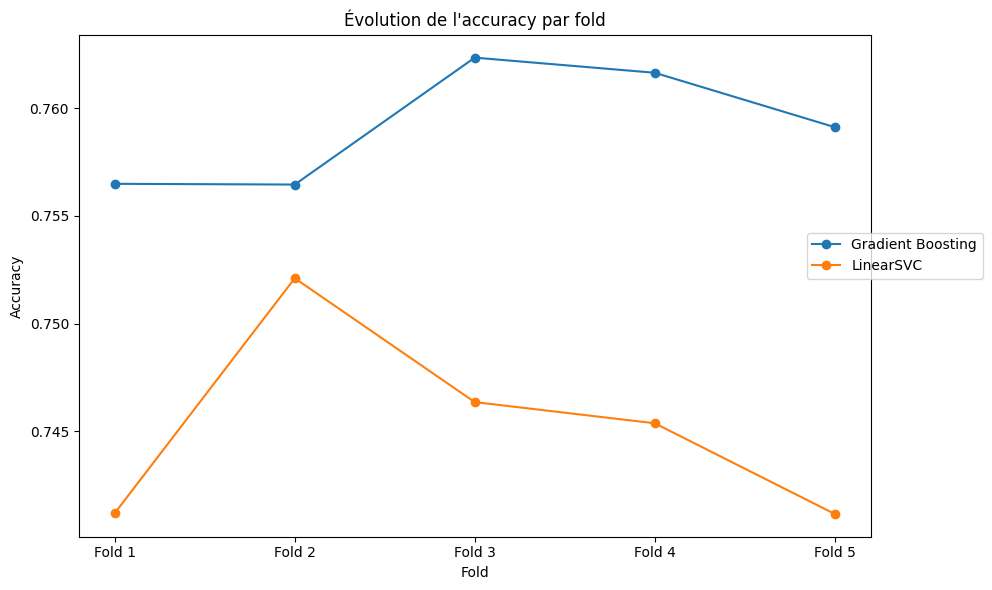

In [34]:
# Résultats de cross-validation
cv_results = {}
n_folds = 5

for name, model in models.items():
    print(f"Cross-validation pour {name}")
    scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='accuracy')
    cv_results[name] = scores

# Convertir en DataFrame
df_cv = pd.DataFrame(cv_results)
df_cv.index = [f"Fold {i+1}" for i in range(n_folds)]

# Afficher les scores
display(df_cv)

# Moyenne et écart-type
summary_df = pd.DataFrame({
    "Modèle": df_cv.columns,
    "Moyenne accuracy": df_cv.mean().values,
    "Écart-type": df_cv.std().values
})
print("\nRésumé des performances (moyenne ± écart-type) :")
display(summary_df)

# Visualisation
plt.figure(figsize=(10, 6))
for model in df_cv.columns:
    plt.plot(df_cv.index, df_cv[model], marker='o', label=model)
plt.title("Évolution de l'accuracy par fold")
plt.ylabel("Accuracy")
plt.xlabel("Fold")
plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0.5))
plt.tight_layout()
plt.show()


# Optimisation des modèles

À partir de notre pipeline, on va optimiser les deux modèles retenus :
LinearSVC (modèle linéaire ) et GradientBoosting (modèle non-linéaire )

### === Resampling & Grid Search ===

Nous avons observé un déséquilibre modéré entre les classes (≈63 % de non-fumeurs vs 37 % de fumeurs).  Pour éviter que les modèles soient biaisés en faveur de la classe majoritaire, nous avons expérimenté des techniques de **resampling**, appliquées uniquement sur le jeu d'entraînement.

 Dans notre cas, nous avons choisi le **RandomUnderSampler**, qui consiste à réduire le nombre de non-fumeurs pour équilibrer la distribution des classes sans introduire de données synthétiques.

Cette étape est suivie d'une **recherche des meilleurs hyperparamètres** par validation croisée (GridSearchCV), en se basant sur la métrique de **rappel (recall)**, qui est importante  pour maximiser la détection des fumeurs.

( Chaque modèle sera traité séparément pour combiner ces deux étapes (resampling + optimisation))


**LinearSVC Pipeline**

In [39]:

# Repartir proprement
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Winsorisation 
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# Undersampling (sur le train uniquement)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Préprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])

# Pipeline avec LinearSVC
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearSVC(max_iter=2000, random_state=42))
])

#  Grille d'hyperparamètres
param_grid = {
    'model__C': [0.01, 0.1, 1, 10]
}

# GridSearch avec rappel en priorité
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

#  Entraînement
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

# Évaluation sur le test 
y_pred = best_model.predict(X_test)

print("Résultats LinearSVC optimisé :")
print("Recall     :", recall_score(y_test, y_pred))
print("F1-score   :", f1_score(y_test, y_pred))
print("Accuracy   :", accuracy_score(y_test, y_pred))
print("Precision  :", precision_score(y_test, y_pred))
print("Best Params:", grid_search.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Résultats LinearSVC optimisé :
Recall     : 0.9347626339969373
F1-score   : 0.7076281010897287
Accuracy   : 0.7169790147009314
Precision  : 0.5692967729901138
Best Params: {'model__C': 1}


**Gradient Boosting Pipeline** 

In [36]:

#  repartir proprement 
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split des données
X_train , X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Winsorisation 
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# Undersampling 
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Pipeline de prétraitement
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])

# Modèle
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

# Grille d'hyperparamètres
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4]
}

# GridSearch avec recall comme métrique
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

# Évaluation
y_pred = best_model.predict(X_test)
print("Recall :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Best Params :", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Recall : 0.9139356814701378
F1-score : 0.7176527176527177
Accuracy : 0.7365054427112557
Precision : 0.5907741041377945
Best Params : {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


### === Sélection des variables ===


In [ ]:
# Récupération du modèle entraîné (LinearSVC)
final_svc = best_model.named_steps['model']
final_preproc = best_model.named_steps['preprocessing']

# ransformation des données train/test avec le prétraitement seul
X_train_processed = final_preproc.transform(X_train)
X_test_processed = final_preproc.transform(X_test)

# Construction des noms de colonnes
all_features = num_cols + ordinal_col + bool_cols

# Création d'un SelectFromModel basé sur les coef_
sfm = SelectFromModel(estimator=final_svc, threshold='median', prefit=True)

# Sélection des colonnes importantes
mask = sfm.get_support()
selected_features = np.array(all_features)[mask]
print(" Variables sélectionnées :", list(selected_features))

# Réduction des données à ces colonnes
X_train_selected = sfm.transform(X_train_processed)
X_test_selected = sfm.transform(X_test_processed)

# Réentraîner un modèle final sur les variables sélectionnées
final_model = LinearSVC(C=grid_search.best_params_['model__C'], max_iter=2000, random_state=42)
final_model.fit(X_train_selected, y_train)

#  Prédictions sur test réduit
y_pred_selected = final_model.predict(X_test_selected)

# 9. Évaluation finale
print("\n Résultats après sélection de variables :")
print("Recall     :", recall_score(y_test, y_pred_selected))
print("F1-score   :", f1_score(y_test, y_pred_selected))
print("Accuracy   :", accuracy_score(y_test, y_pred_selected))
print("Precision  :", precision_score(y_test, y_pred_selected))


 Variables sélectionnées : [np.str_('height(cm)'), np.str_('weight(kg)'), np.str_('systolic'), np.str_('Cholesterol'), np.str_('triglyceride'), np.str_('hemoglobin'), np.str_('serum_creatinine'), np.str_('ALT'), np.str_('Gtp'), np.str_('dental_caries'), np.str_('tartar'), np.str_('homme')]

 Résultats après sélection de variables :
Recall     : 0.7240428790199082
F1-score   : 0.6844238563983787
Accuracy   : 0.7553585456177758
Precision  : 0.6489157287949492
